In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [12]:
# Transform: Normalize images between [-1, 1] (because Tanh will be used as output)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load MNIST
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

In [22]:
# DataLoader
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [23]:
class Generator(nn.Module):
    def __init__(self, noise_dim=100, out_img_dim=784):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(noise_dim, 256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.Linear(512, 1024),
            nn.ReLU(True),
            nn.Linear(1024, out_img_dim),
            nn.Tanh()   # Because we normalize images [-1, 1]
        )
    def forward(self, z):
        return self.model(z)

In [24]:
class Discriminator(nn.Module):
    def __init__(self, in_img_dim=784):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(in_img_dim, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()    # Outputs probability between 0 and 1
        )
    def forward(self, img):
        return self.model(img)

In [25]:
noise_dim = 100
img_dim = 28 * 28

# Models
generator = Generator(noise_dim, img_dim).to(device)
discriminator = Discriminator(img_dim).to(device)

# Optimizers
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002)
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)

# Loss
criterion = nn.BCELoss()

In [26]:
def show_generated_images(epoch, generator, fixed_noise):
    generator.eval()
    with torch.no_grad():
        fake_imgs = generator(fixed_noise).reshape(-1, 1, 28, 28)
        fake_imgs = fake_imgs * 0.5 + 0.5   # de normalize
    grid = torchvision.utils.make_grid(fake_imgs, nrow=8)
    plt.figure(figsize=(8, 8))
    plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
    plt.axis('off')
    plt.show()
    generator.train()

In [27]:
def train_gan(train_loader, num_epochs, mode="one_one"):
    fixed_noise = torch.randn(64, noise_dim).to(device) # for consistence viz
    for epoch in range(num_epochs):
        for batch_idx, (real, _) in enumerate(train_loader):
            batch_size = real.size(0)
            real = real.view(batch_size, -1).to(device)
            # Create real and fake labels
            real_labels = torch.ones(batch_size, 1).to(device)
            fake_labels = torch.zeros(batch_size, 1).to(device)

            # ------------------------------- #
            # ----- Train Discriminator ----- #
            # ------------------------------- #

            # Real images
            outputs = discriminator(real)
            d_loss_real = criterion(outputs, real_labels)
            real_score = outputs

            # Fake images
            z = torch.randn(batch_size, noise_dim).to(device)
            fake = generator(z)
            outputs = discriminator(fake.detach())  # detach so gradient doesn't flow into generator
            d_loss_fake = criterion(outputs, fake_labels)
            fake_score = outputs

            # Total discriminator loss
            d_loss = d_loss_real + d_loss_fake

            # Update discriminator
            discriminator.zero_grad()
            d_loss.backward()
            d_optimizer.step()

            # ------------------------------- #
            # ------- Train Generator ------- #
            # ------------------------------- #

            # Generate fake images again
            z = torch.randn(batch_size, noise_dim).to(device)
            fake = generator(z)
            outputs = discriminator(fake)

            g_loss = criterion(outputs, real_labels)    # Trick discriminator

            # Update generator
            generator.zero_grad()
            g_loss.backward()
            g_optimizer.step()

            # ---------------------------------------- #
            # ------- Modify according to mode ------- #
            # ---------------------------------------- #
            if mode=="five_gen_one_disc":
                for _ in range(4):  # already did one step above
                    # Generate fake images again
                    z = torch.randn(batch_size, noise_dim).to(device)
                    fake = generator(z)
                    outputs = discriminator(fake)
                    g_loss = criterion(outputs, real_labels)    # Trick discriminator
                    generator.zero_grad()
                    g_loss.backward()
                    g_optimizer.step()
            if mode=="five_disc_one_gen":
                for _ in range(4):  # already did one step above
                    # Real
                    outputs = discriminator(real)
                    d_loss_real = criterion(outputs, real_labels)
                    real_score = outputs

                    # Fake
                    z = torch.randn(batch_size, noise_dim).to(device)
                    fake = generator(z)
                    outputs = discriminator(fake.detach())
                    d_loss_fake = criterion(outputs, fake_labels)
                    # fake_score = outputs

                    # Total
                    d_loss = d_loss_real + d_loss_fake
                    discriminator.zero_grad()
                    d_loss.backward()
                    d_optimizer.step()
        if (epoch+1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Discriminator Loss: {d_loss.item():.4f}, Generator Loss: {g_loss.item():.4f}")
            show_generated_images(epoch, generator, fixed_noise)

Training: One step gen, One step dis
Epoch [10/50], Discriminator Loss: 0.2328, Generator Loss: 7.9157


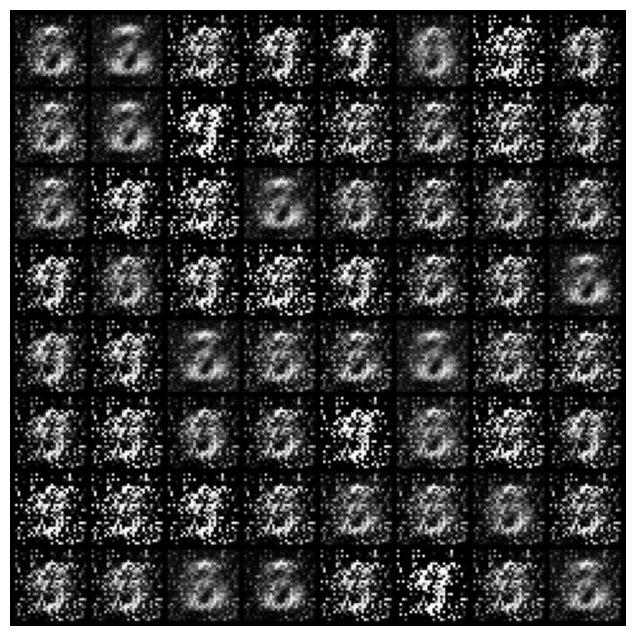

Epoch [20/50], Discriminator Loss: 0.3440, Generator Loss: 4.5648


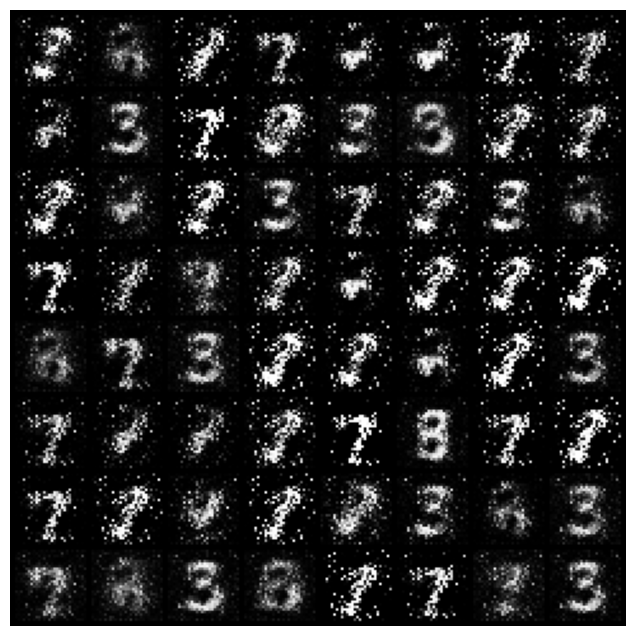

Epoch [30/50], Discriminator Loss: 0.5374, Generator Loss: 3.4021


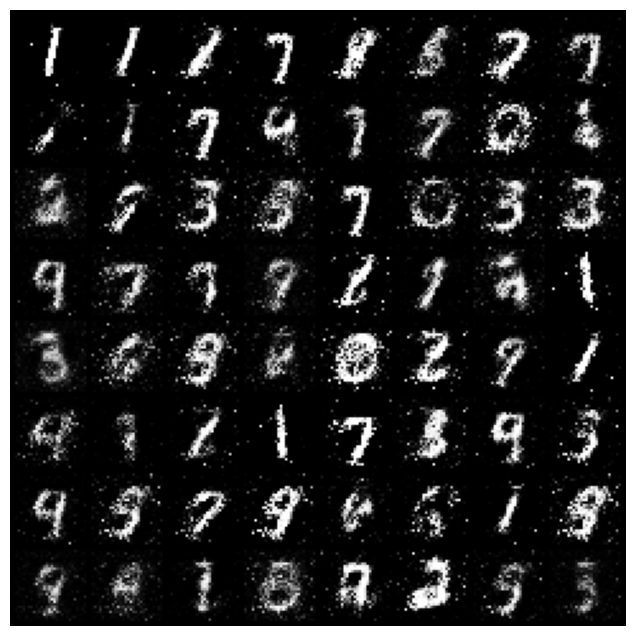

Epoch [40/50], Discriminator Loss: 0.5241, Generator Loss: 2.1519


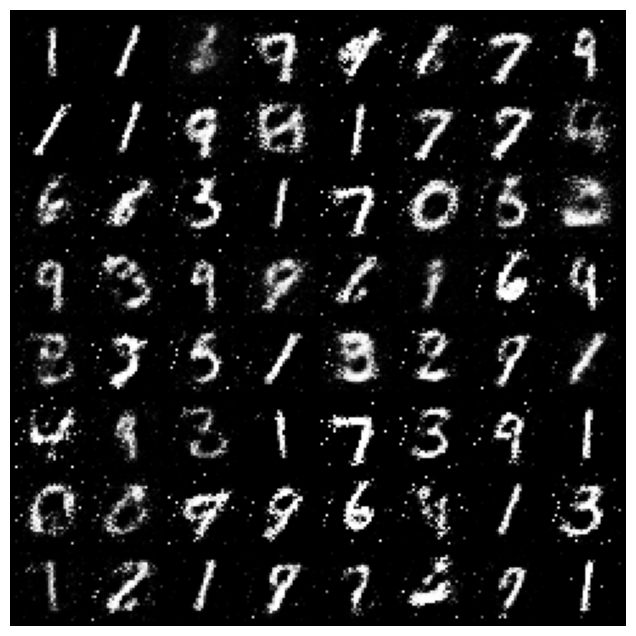

Epoch [50/50], Discriminator Loss: 1.0691, Generator Loss: 1.7622


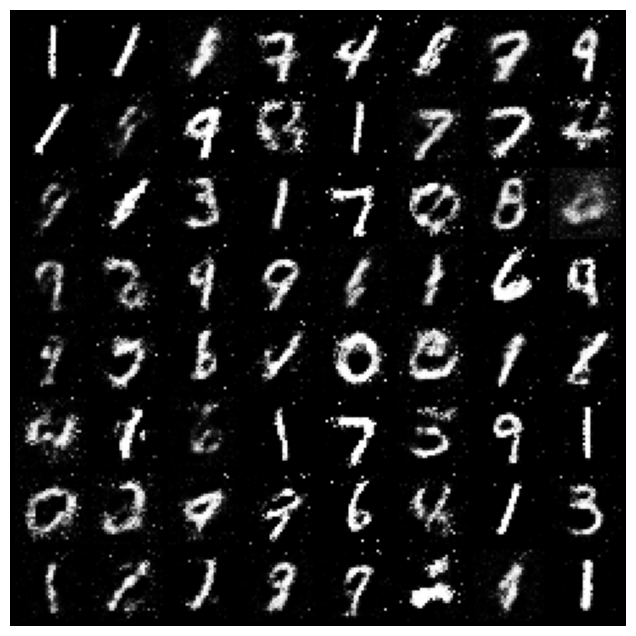

Training: One step gen, One step dis
Epoch [10/50], Discriminator Loss: 0.0000, Generator Loss: 13.6336


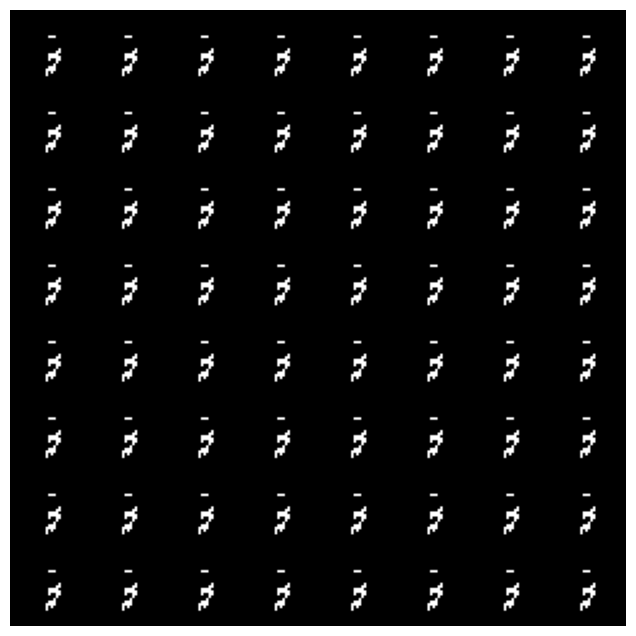

Epoch [20/50], Discriminator Loss: 0.0000, Generator Loss: 17.5723


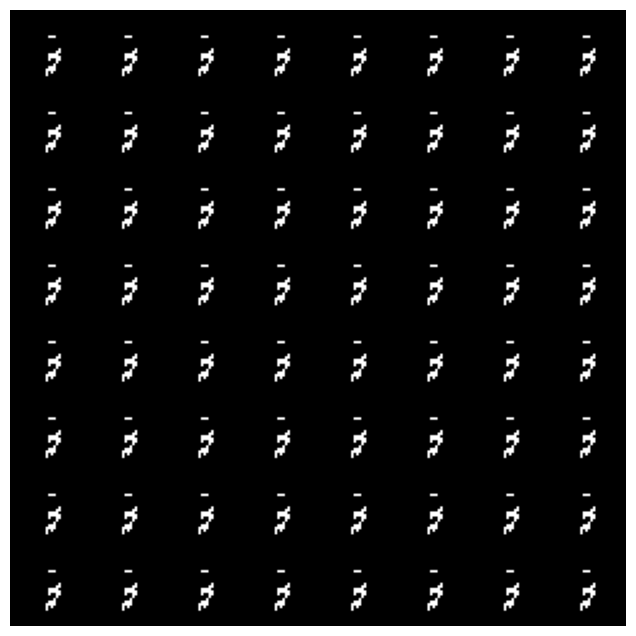

Epoch [30/50], Discriminator Loss: 0.0000, Generator Loss: 22.0467


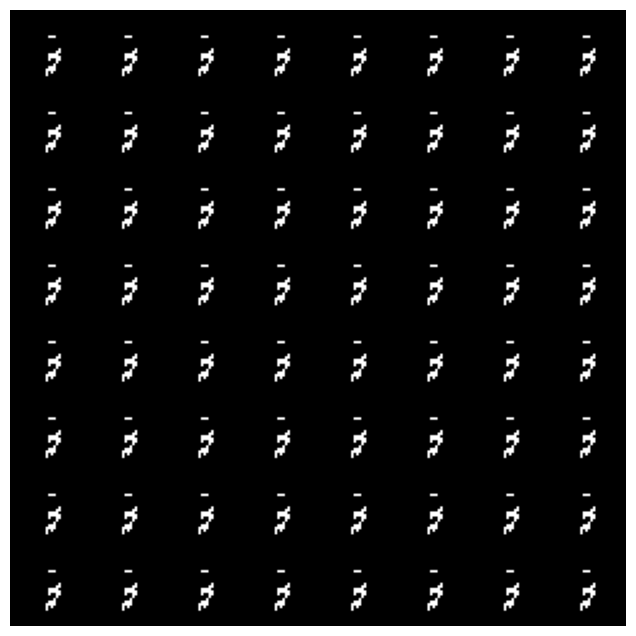

Epoch [40/50], Discriminator Loss: 0.0000, Generator Loss: 25.5677


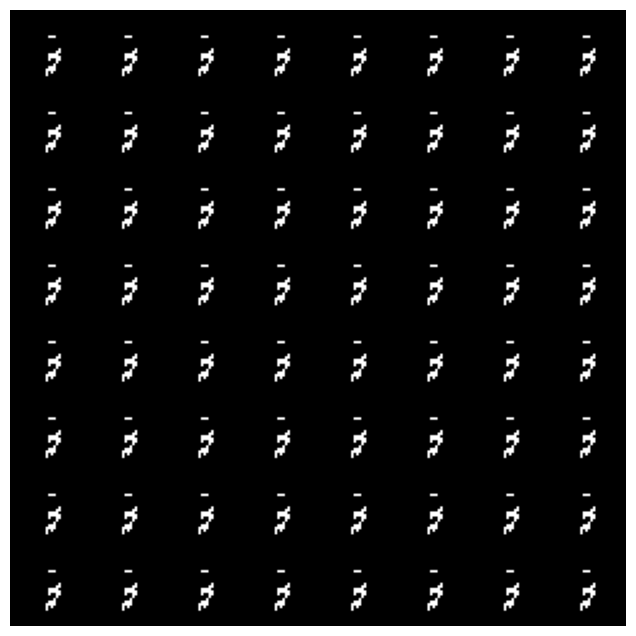

Epoch [50/50], Discriminator Loss: 0.0000, Generator Loss: 27.3795


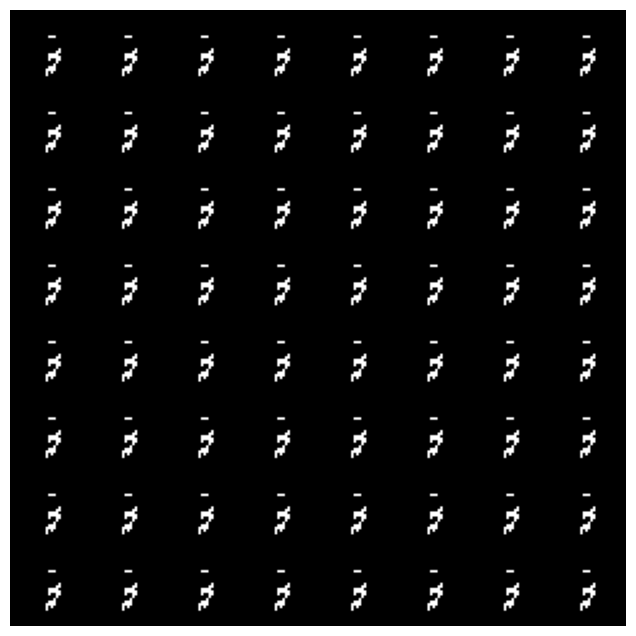

Training: One step gen, One step dis
Epoch [10/50], Discriminator Loss: 0.0000, Generator Loss: 28.7077


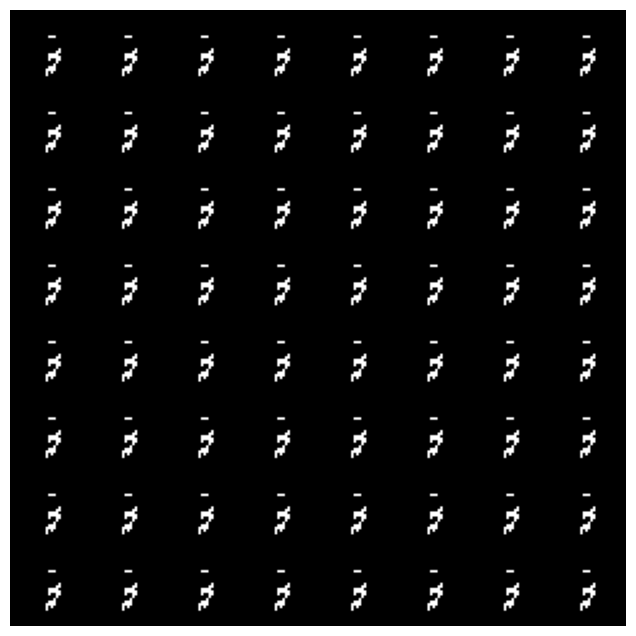

Epoch [20/50], Discriminator Loss: 0.0000, Generator Loss: 29.0322


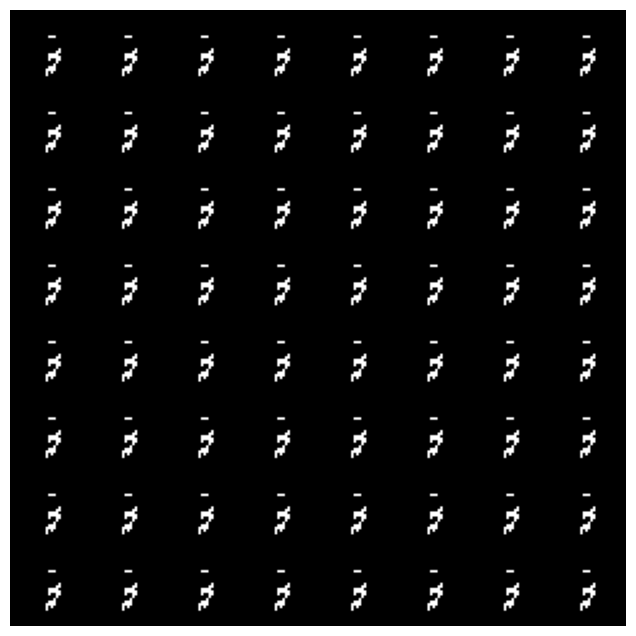

Epoch [30/50], Discriminator Loss: 0.0000, Generator Loss: 29.1146


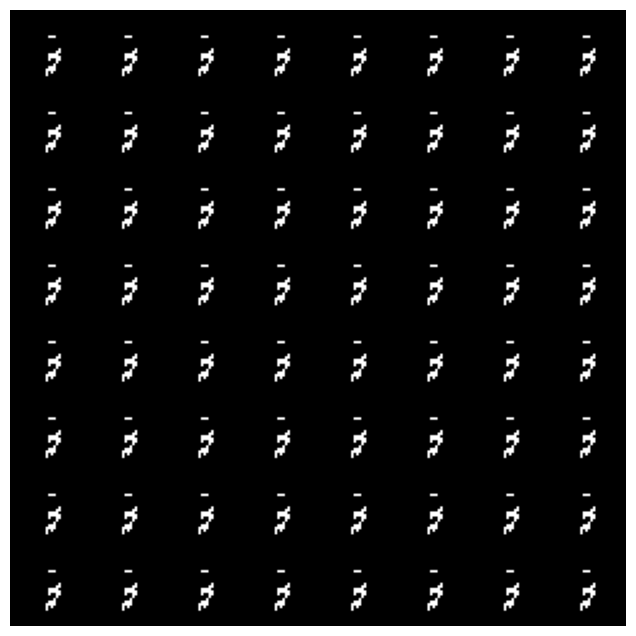

In [ ]:
# 1. Standard: One step generator, One step discriminator
print("Training: One step gen, One step dis")
train_gan(train_loader, num_epochs=50, mode="one_one")

# 2. 5 generator steps, 1 discriminator steps
print("Training: Five step gen, One step dis")
train_gan(train_loader, num_epochs=50, mode="five_gen_one_disc")

# 3. 5 discriminator step, 1 generator step
print("Training: Five step disc, One step gen")
train_gan(train_loader, num_epochs=50, mode="five_disc_one_gen")